# Fully Supervised with Self-Supervised Embedding Evaluation 

This is an notebook attempting to replicate the results of the fully supervised with self-supervised embedding evaluation process proposed in the TypiClust paper. 

As following the paper, the budget size will be 10 (equal to the number of classes in CIFAR10). The initial labelled set L₀ was empty (∅), requiring initial pooling. With all sampling methods being compared over 5 iterative query rounds. The test/validation accuracy will be average across 10 repetitions.

The follow training configurations are also followed: 

Model: A linear classifier is trained using these features on the queried labeled set. These features are the self-supervised embeddings are extracted during the representation learning step. A single linear layer of size d×C (where d is feature dimensions and C is the number of classes) is optimised. Training adjustments include increasing the learning rate to 2.5 and doubling the number of epochs due to shorter training times (200 epochs). 

This notebook will be comparing random, TypiClust and TypiclustPlus performances and evaluating them.


There is also an option to save each result locally as a JSON file. This is the format of the JSON file: 

```json
{
  "rep 0": [
    {
      "val iter 0 acc/loss": [float, float],
      "val iter 1 acc/loss": [float, float],
      ...
      "val iter i acc/loss": [float, float]
    },
    {
      "train iter 0": [
        (epoch float, accuracy float), 
        ... 
        (epoch float, accuracy float)
      ],
      "train iter 1": [
        (epoch float, accuracy float), 
        ... 
        (epoch float, accuracy float)
      ],
      ...
      "train iter i": [
        (epoch float, accuracy float), 
        ... 
        (epoch float, accuracy float)
      ]
    }
  ]
}

```

- The outermost key `"rep 0"` represents a specific training run or repetition.
- The first object within `"rep 0"` contains validation results with keys like `"val iter 0 acc/loss"` storing accuracy and loss as `[float, float]`.
- The second object contains training results for different iterations, with each key like `"train iter 0"` storing a list of tuples representing `(epoch, accuracy)`.



# Imports 

In [ ]:
import torchvision 
import torch 
import torch.nn as nn
import numpy as np 
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, MiniBatchKMeans
import pandas as pd 
import matplotlib.pyplot as plt 
import torch.optim.sgd
import random
from simclr_pretrained.resnet_cifar import resnet18
# from typiclustPlus import TypiclustPlus
# from typiclust import Typiclust 
from typiclust import Typiclust
from typiclustPlus import TypiclustPlus
from scipy import stats
import scikit_posthocs

import json 

np.random.seed(42)
# torch.manual_seed()
torch.cuda.is_available()

True

# Variables 

In [5]:
DEVICE = torch.device('cuda')
LR = 2.5
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0003 
NESTEROV = True
DATA_DIR = "./datasets"
BUDGET_SIZE = 10 
N_REPS = 10
ITERATIONS = 5 
EPOCHS = 200

# Setup

In [6]:
# Normalisation 
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Define Datasets and Dataloaders 
train_dataset =  torchvision.datasets.CIFAR10(DATA_DIR, train=True,
                                                transform=transform,
                                                download=True)

val_dataset =  torchvision.datasets.CIFAR10(DATA_DIR, train=False,
                                            transform=transform,
                                            download=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=10, shuffle=False,
        num_workers=0, pin_memory=True, drop_last=False)

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=10, shuffle=False,
        num_workers=0, pin_memory=True, drop_last=False)


In [ ]:
# Load SimCLR Model  
pt_model = resnet18()["backbone"]
state_dict = torch.load("simclr_cifar-10.pth")
new_state_dict = {}

# Remove Projection head 
for key, value in state_dict.items():
    # Format
    if key.startswith("backbone."):
        new_key = key.replace("backbone.", "")
        new_state_dict[new_key] = value
    if key.startswith("contrastive_head."):
        continue

pt_model.load_state_dict(new_state_dict,strict=True)
pt_model.to(DEVICE)

In [ ]:
# Extract representations for the training set 
feats, labels = [], []
for batch_imgs, batch_labels in tqdm(train_loader):
    batch_imgs = batch_imgs.to(DEVICE)
    batch_feats = pt_model(batch_imgs)
    feats.append(batch_feats.detach().cpu())
    labels.append(batch_labels)

feats = torch.cat(feats, dim=0)
labels = torch.cat(labels, dim=0)

# Save representations locally 
feat_path = f'{DATA_DIR}/embedded_supervised_feats.npy'
labels_path = f'{DATA_DIR}/embedded_supervised_labels.npy'

with open(feat_path, 'wb') as f: 
    np.save(f, feats)

with open(labels_path, 'wb') as f: 
    np.save(f, labels)

# Load training features 
train_feats = np.load(feat_path)
train_labels = np.load(labels_path)

100%|██████████| 5000/5000 [00:48<00:00, 103.00it/s]


In [ ]:
# Extract representations for the validation set
feats, labels = [], []
for batch_imgs, batch_labels in tqdm(val_loader):
    batch_imgs = batch_imgs.to(DEVICE)
    batch_feats = pt_model(batch_imgs)
    feats.append(batch_feats.detach().cpu())
    labels.append(batch_labels)

val_feats = torch.cat(feats, dim=0)
val_labels = torch.cat(labels, dim=0)

# Save representations locally
val_feat_path = f'{DATA_DIR}/val_embedded_supervised_feats.npy'
val_labels_path = f'{DATA_DIR}/val_embedded_supervised_labels.npy'
 
with open(val_feat_path, 'wb') as f: 
    np.save(f, val_feats)

with open(val_labels_path, 'wb') as f: 
    np.save(f, val_labels)

# Load 
val_feats = np.load(val_feat_path)
val_labels = np.load(val_labels_path)

100%|██████████| 1000/1000 [00:09<00:00, 102.89it/s]


In [ ]:
# Construct feature representation datasets 

# Format into Tensors 
val_feats = torch.from_numpy(val_feats)
val_labels = torch.from_numpy(val_labels)
train_feats = torch.from_numpy(train_feats)
train_labels = torch.from_numpy(train_labels)

# Train dataset 
f_train_dataset = torch.utils.data.TensorDataset(train_feats, train_labels)
f_train_loader = torch.utils.data.DataLoader(
        f_train_dataset, batch_size=10, shuffle=False,
        num_workers=0, pin_memory=True, drop_last=False)

# Validation dataset 
f_val_dataset = torch.utils.data.TensorDataset(val_feats, val_labels)
f_val_loader = torch.utils.data.DataLoader(
        f_val_dataset, batch_size=10, shuffle=False,
        num_workers=0, pin_memory=True, drop_last=False)

In [7]:
def init_model():
    """Initalise Linear Classifier"""
    model = nn.Linear(512,10)
    criterion = nn.CrossEntropyLoss()  
    optimizer = torch.optim.SGD(model.parameters(), lr=LR,
                                momentum=MOMENTUM, nesterov=NESTEROV)
    
    return model, criterion, optimizer

def train(epochs, train_loader, model, criterion, optimizer):
    """Train Linear Classifier"""
    model.train()

    # Accuracy for each Epoch 
    train_accuracies = []

    for epoch in range(epochs):
        correct, total = 0, 0

        for input, label in train_loader:
            # Zero gradients for every batch
            optimizer.zero_grad()

            # Compute predictions 
            output = model(input)
            loss = criterion(output, label)

            # Perform backpropagation
            loss.backward() # Compute gradients 
            optimizer.step() # Update model parameters 

            # Compute training accuracy 
            _, predicted = torch.max(output, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

        train_accuracies.append((epoch, 100 * correct / total))
    return train_accuracies

def eval(test_loader, model, criterion):
    """Evaluate model on CIFAR10 Validation set embeddings"""
    # Set model to evaluation 
    model.eval() 

    running_vloss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for input, label in test_loader:
            output = model(input)
            
            _, predicted = torch.max(output, 1)
            
            # Compute loss
            loss = criterion(output, predicted)
            running_vloss += loss.item()

            # Compute validation accuracy
            total += label.size(0)
            correct += (predicted == label).sum().item()

    print(f"\n\nVal Acc: {100 * correct / total}")
    avg_vloss = (running_vloss / len(test_loader))
    
    return [100 * correct / total, avg_vloss]


# Random Sampling

### Functions 

In [44]:
def random_sample(dataset, budget_size, l_set_indices):
    """
    Random sampling 
    
    Args: 
    dataset (torchvision.datasets): CIFAR10 training dataset 
    budget_size (int): sample size 
    l_set_indices List[int]: labelled data points indices 

    Returns: 
    l_set (torch.utils.data.Subset) : Labelled dataset 
    l_set_indices List[int]: Updated labelled data points indices 
    """
    
    # Shuffle un-labelled dataset 
    tempIdx = [i for i in range(len(dataset))]
    ids = list(set(tempIdx) - set(l_set_indices))
    np.random.shuffle(ids)

    # Add to unlabelled-set 
    l_set_indices+= ids[0:budget_size]
    l_set = torch.utils.data.Subset(dataset,  l_set_indices)

    return l_set, l_set_indices

In [46]:
def random_al(budget_size, iterations, epochs):
    """
    Random Sampling Active Learning Loop for n iterations
    """
    l_set_indices = []

    print("---Initial Pooling / L0 Set Extraction--")
    l_set, l_set_indices = random_sample(
                                f_train_dataset,
                                budget_size, 
                                l_set_indices)
    print("--Loading model--")
    model, criterion, optimizer = init_model() 

    print("--Starting Active Learning--")
    train_results = {}
    val_results = {}

    for i in range(iterations+1):
        print(f"Iteration {i+1}:")
        print(f"L set size: {len(l_set_indices)}")
        print(f"L set indices: {l_set_indices}")

        # Load labelled dataset 
        l_set_loader = torch.utils.data.DataLoader(
            l_set, batch_size=budget_size, shuffle=False,
            num_workers=0, pin_memory=True, drop_last=False)
        
        # Train for n epochs 
        train_accuracies = train(epochs, 
                                 l_set_loader, 
                                 model, 
                                 criterion, 
                                 optimizer)
        
        # Evaluate current model 
        val_accuracies = eval( 
                              f_val_loader, 
                              model,   
                              criterion            
                              )
        
        # Add results 
        val_results[f'val iter {i} acc/loss'] = val_accuracies
        train_results[f'train iter {i} acc'] = train_accuracies

        if i != iterations:
            l_set, l_set_indices = random_sample(
                                            f_train_dataset, 
                                             budget_size, 
                                             l_set_indices)
        print("\n\n")
    return val_results, train_results 
        

### Active Learning Loop

In [47]:
random_results = {}

for rep in range(N_REPS):
    print(f"---Repetition {rep+1}---")
    val_acc, train_acc = random_al(budget_size=BUDGET_SIZE,
                                   iterations=ITERATIONS,
                                   epochs=EPOCHS,
                                    )
    
    random_results[f'rep {rep}'] = (val_acc, train_acc)

---Repetition 1---
---Initial Pooling / L0 Set Extraction--
--Loading model--
--Starting Active Learning--
Iteration 1:
L set size: 10
L set indices: [30632, 10477, 23711, 28197, 26337, 40624, 9639, 1898, 46544, 2931]


Val Acc: 31.42



Iteration 2:
L set size: 20
L set indices: [30632, 10477, 23711, 28197, 26337, 40624, 9639, 1898, 46544, 2931, 40724, 44304, 38451, 16575, 19943, 25026, 38571, 28623, 36738, 13257]


Val Acc: 38.34



Iteration 3:
L set size: 30
L set indices: [30632, 10477, 23711, 28197, 26337, 40624, 9639, 1898, 46544, 2931, 40724, 44304, 38451, 16575, 19943, 25026, 38571, 28623, 36738, 13257, 29565, 49606, 21049, 10893, 46339, 23090, 29366, 5647, 34783, 2975]


Val Acc: 45.58



Iteration 4:
L set size: 40
L set indices: [30632, 10477, 23711, 28197, 26337, 40624, 9639, 1898, 46544, 2931, 40724, 44304, 38451, 16575, 19943, 25026, 38571, 28623, 36738, 13257, 29565, 49606, 21049, 10893, 46339, 23090, 29366, 5647, 34783, 2975, 35633, 34614, 47758, 32126, 41736, 8602, 23

### Save Locally 

In [48]:
out_file = open(f"{DATA_DIR}/random_embedding_supervised.json", "w")

json.dump(random_results, out_file, indent = 6)

out_file.close()

# TypiClust

### Functions

In [49]:
def typi_al(budget_size, iterations, epochs):
    l_set_indices = []

    args = {
            'data_dir' : DATA_DIR, 
            'dataset_name' : 'cifar10',
            'device' : DEVICE,
        }
    
    print("---Initial Pooling / L0 Set Extraction--")
    tpc = Typiclust(f_train_dataset,
                    train_loader,
                    budget_size,
                    l_set_indices,
                    args)
    
    print(f"Sampling {budget_size} budget")
    l_set, l_set_indices= tpc.sample(l_set_indices)

    print("--Loading model--")
    model, criterion, optimizer = init_model() 

    print("--Starting Active Learning--")
    train_results = {}
    val_results = {}

    for i in range(iterations+1):
        print(f"Iteration {i+1}:")
        print(f"L set size: {len(l_set_indices)}")
        print(f"L set indices: {l_set_indices}")
        
        
        # Load labelled dataset
        l_set_loader = torch.utils.data.DataLoader(
            l_set, batch_size=10, shuffle=False,
            num_workers=0, pin_memory=True, drop_last=False)
        
        # Train
        train_accuracies = train(epochs, 
                                 l_set_loader, 
                                 model, 
                                 criterion, 
                                 optimizer)
        
        # Evaluate 
        val_accuracies = eval( 
                              f_val_loader, 
                              model,   
                              criterion            
                              )
        
        # Add results 
        val_results[f'val iter {i} acc/loss'] = val_accuracies
        train_results[f'train iter {i} acc'] = train_accuracies

        if i != iterations:
            print(f"Sampling {budget_size} samples...")
            l_set, l_set_indices= tpc.sample(l_set_indices)

        print("\n\n")
    return val_results, train_results 


### Active Learning Loop

In [57]:
typi_results = {}

# Repeat Active Learning for n times 
for rep in range(N_REPS):
    print(f"---Repetition {rep+1}---")
    val_acc, train_acc = typi_al(budget_size=BUDGET_SIZE,
                                   iterations=ITERATIONS,
                                   epochs=EPOCHS,
                                )
    typi_results[f'rep {rep}'] = (val_acc, train_acc)

---Repetition 1---
---Initial Pooling / L0 Set Extraction--
Loaded features in locally
Sampling 10 budget
--Loading model--
--Starting Active Learning--
Iteration 1:
L set size: 10
L set indices: [36361, 44967, 28697, 41614, 48689, 31572, 5666, 28221, 44626, 2102]


Val Acc: 41.33
Sampling 10 samples...



Iteration 2:
L set size: 20
L set indices: [36361, 44967, 28697, 41614, 48689, 31572, 5666, 28221, 44626, 2102, 4545, 12091, 15790, 29674, 26956, 29435, 15481, 11418, 31146, 48099]


Val Acc: 46.39
Sampling 10 samples...



Iteration 3:
L set size: 30
L set indices: [36361, 44967, 28697, 41614, 48689, 31572, 5666, 28221, 44626, 2102, 4545, 12091, 15790, 29674, 26956, 29435, 15481, 11418, 31146, 48099, 25826, 18699, 7429, 10673, 7250, 18860, 1959, 38926, 43423, 16831]


Val Acc: 54.81
Sampling 10 samples...



Iteration 4:
L set size: 40
L set indices: [36361, 44967, 28697, 41614, 48689, 31572, 5666, 28221, 44626, 2102, 4545, 12091, 15790, 29674, 26956, 29435, 15481, 11418, 31146, 480

### Local save

In [60]:
out_file = open(f"{DATA_DIR}/typiclust_embedding_supervised.json", "w")
json.dump(typi_results, out_file, indent = 6)
out_file.close()

# TypiClust Plus

### Functions

In [22]:
def typiplus_al(budget_size, iterations, epochs):
    l_set_indices = []

    # TypiclustPlus arguments 
    args = {
            'data_dir' : DATA_DIR, 
            'dataset_name' : 'cifar10',
            'device' : DEVICE,
            'alpha' : 1.0,
            'beta' : 1.0,
            'gamma' : 0.01,
        }
    
    print("---Initial Pooling / L0 Set Extraction--")
    tpc = TypiclustPlus(f_train_dataset,
                    train_loader,
                    budget_size,
                    l_set_indices,
                    args)
    
    print(f"Sampling {budget_size} budget")
    l_set, l_set_indices= tpc.sample(l_set_indices)

    print("--Loading model--")
    model, criterion, optimizer = init_model() 

    print("--Starting Active Learning--")
    train_results = {}
    val_results = {}

    for i in range(iterations+1):
        print(f"Iteration {i+1}:")
        print(f"L set size: {len(l_set_indices)}")
        print(f"L set indices: {l_set_indices}")
        
        
        # Load labelled dataset
        l_set_loader = torch.utils.data.DataLoader(
            l_set, batch_size=10, shuffle=False,
            num_workers=0, pin_memory=True, drop_last=False)
        
        # Train
        train_accuracies = train(epochs, 
                                 l_set_loader, 
                                 model, 
                                 criterion, 
                                 optimizer)
        
        # Evaluate 
        val_accuracies = eval( 
                              f_val_loader, 
                              model,   
                              criterion            
                              )
        
        # Add results 
        val_results[f'val iter {i} acc/loss'] = val_accuracies
        train_results[f'train iter {i} acc'] = train_accuracies

        if i != iterations:
            print(f"Sampling {budget_size} samples...")
            l_set, l_set_indices= tpc.sample(l_set_indices)

        print("\n\n")
    return val_results, train_results 


### Active Learning Loop

In [40]:
typiplus_results = {}

# Repeat Active Learning for n times 
for rep in range(N_REPS):
    print(f"---Repetition {rep+1}---")
    val_acc, train_acc = typiplus_al(budget_size=BUDGET_SIZE,
                                   iterations=ITERATIONS,
                                   epochs=EPOCHS,
                                )
    typiplus_results[f'rep {rep}'] = (val_acc, train_acc)

---Repetition 1---
---Initial Pooling / L0 Set Extraction--
Loaded features in locally
Sampling 10 budget
Loaded typiclustplus_cifar10_budget_10.npy locally
--Loading model--
--Starting Active Learning--
Iteration 1:
L set size: 10
L set indices: [38604, 36281, 26075, 13534, 19334, 8133, 30564, 48308, 8304, 4410]


Val Acc: 48.14
Sampling 10 samples...
    cluster_id  labelled_count  cluster_size
0            6               0          7036
1            7               0          5112
2           14               0          2910
3           11               0          2897
4            3               0          2553
5           16               0          2404
6           18               0          2122
7           12               0          2054
8           10               0          1745
9            9               0          1496
10          17               0          1051
11           4               1          3587
12           0               1          3411
13          15 

### Local Save

In [41]:
out_file = open(f"{DATA_DIR}/typiclustplus_embedding_supervised.json", "w")
json.dump(typiplus_results, out_file, indent = 6)
out_file.close()

# Plot

If you have previously saved results as JSON, you can load them in. Though this is un-needed if the whole notebook has been previously executed in this run time. 

In [7]:
# OPTIONAL 
f = open(f"{DATA_DIR}/typiclustplus_embedding_supervised.json")
typiplus_results = json.load(f)

f = open(f"{DATA_DIR}/random_embedding_supervised.json")
random_results = json.load(f)

f = open(f"{DATA_DIR}/typiclust_embedding_supervised.json")
typi_results = json.load(f)

In [8]:
a = 0.05 

# Map sampling technique to the results collected from the AL iterations
sample_results = {"TypiClust" : typi_results,
                  "TypiClust Plus" : typiplus_results,
                  "Random" : random_results}

sample_kruskal = [] 
sample_means = []
sample_stds = []

# Loop through all sampling technique results 
for __, result in sample_results.items():
    budget_size_val_accuracies = [[] for i in range(ITERATIONS+1)]

    # Collect all validation accuarcies for each budget size 
    for rep, values in result.items():
        iter_count = 0 
        for iter, val_metrics in values[0].items():
            val_acc = val_metrics[0]
            budget_size_val_accuracies[iter_count].append(val_acc)
            iter_count += 1 
    sample_kruskal.append(budget_size_val_accuracies)

    # Calculate the mean and std for each budget size 
    budget_size_means = np.array([np.mean(b) for b in budget_size_val_accuracies])
    budget_size_stds = np.array([np.std(b) for b in budget_size_val_accuracies])

    # Add sample technique means/std to a list of all techniques used 
    sample_means.append(budget_size_means)
    sample_stds.append(budget_size_stds)

# Statistical Analysis 
print(f"Kruskal-Wallis P-value test w/ Post hoc\nSig level:{a}")
for i in range(ITERATIONS+1):
    typi = sample_kruskal[0][i]
    typiplus = sample_kruskal[1][i]
    random = sample_kruskal[2][i]
    print("---------")
    print(f"Budget {i*10+10} P-Value: {(stats.kruskal(typi, typiplus, random)[-1])}\n")

    post_hoc = scikit_posthocs.posthoc_dunn([typi,typiplus,random])
    print("Post hoc Dunn's test")
    print(post_hoc)
    print('\n\n')

Kruskal-Wallis P-value test w/ Post hoc
Sig level:0.05
---------
Budget 10 P-Value: 2.482866004030669e-06

Post hoc Dunn's test
          1             2             3
1  1.000000  1.107621e-02  1.107621e-02
2  0.011076  1.000000e+00  3.763035e-07
3  0.011076  3.763035e-07  1.000000e+00



---------
Budget 20 P-Value: 2.4757442300763816e-06

Post hoc Dunn's test
          1             2             3
1  1.000000  1.106726e-02  1.106726e-02
2  0.011067  1.000000e+00  3.751852e-07
3  0.011067  3.751852e-07  1.000000e+00



---------
Budget 30 P-Value: 2.4474295056819355e-06

Post hoc Dunn's test
          1             2             3
1  1.000000  1.103150e-02  1.103150e-02
2  0.011031  1.000000e+00  3.707399e-07
3  0.011031  3.707399e-07  1.000000e+00



---------
Budget 40 P-Value: 7.829360208041489e-06

Post hoc Dunn's test
          1         2         3
1  1.000000  0.005176  0.042016
2  0.005176  1.000000  0.000001
3  0.042016  0.000001  1.000000



---------
Budget 50 P-Value: 7.

Collate all results and calculate the means and standard deviations of each budget size for each sampling technique experimented with. 

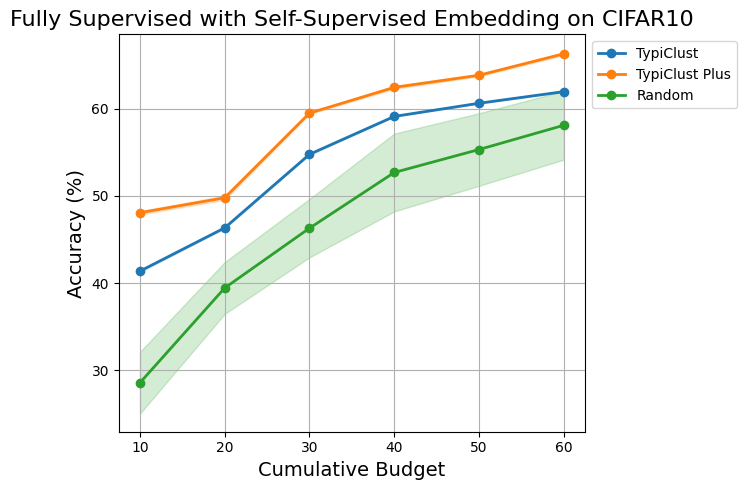

In [9]:
# X-axis labels 
cumulative_budget = np.linspace(10, 60, 6)

# Plotting
plt.figure(figsize=(7, 5))

colors = plt.cm.tab20.colors  # Use a colormap for variety

# Plot for each sampling technique 
for i, (mean, std) in enumerate(zip(sample_means, sample_stds)):
    # Plot mean 
    plt.plot(cumulative_budget, 
             mean, 
             color=colors[2*i], 
             marker='o', 
             linewidth=2, 
             label=list(sample_results.keys())[i])
    
    # Plot variance 
    plt.fill_between(cumulative_budget, mean - std, mean + std, color=colors[2*i], alpha=0.2)

# Labels and Legend
plt.xlabel('Cumulative Budget', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Fully Supervised with Self-Supervised Embedding on CIFAR10', fontsize=16)
plt.legend(loc='upper left', fontsize=10, bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()